In [2]:
################################ config #################################

#!/usr/bin/env python3
from datetime import datetime
from time import time
from astropy.io import fits
import numpy as np
import glob
import tqdm
import cupy as cp
import cuml
#from progressbar import progressbar

# parameters

stride = 4
win_size_large = 16
win_size_small = 4
clusters = 3

# Imports
import numpy as np
import sunpy
import sunpy.map
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS

# Channels
nb_channels = 3
cmaps = ['sohoeit171', 'sohoeit195', 'sohoeit304']

# Files
path_to_files = '../../data_hw20/'
filenames_171 = sorted(glob.glob(path_to_files+'fullSunMap_171_eit_l1_*'))
filenames_195 = sorted(glob.glob(path_to_files+'fullSunMap_195_eit_l1_*'))
filenames_304 = sorted(glob.glob(path_to_files+'fullSunMap_304_eit_l1_*'))
filenames_masks = sorted(glob.glob(path_to_files+'EUVI*'))
nb_files = len(filenames_195)
print('Number of files per channel: {0}'.format(nb_files))

Number of files per channel: 703


In [3]:
class synchronic_map():
    def __init__(self):
        pass

    def plot_map_object(self, map_object, cmap):

        ny, nx = map_object.data.shape
        map_object.plot_settings['cmap'] = plt.get_cmap(cmap)
        # map_object.plot_settings['norm'] = ImageNormalize(map_object.data)
        map_object.plot_settings['norm'] = colors.LogNorm()

        plt.figure(figsize=(10, 5))
        ax = plt.subplot(projection=map_object.wcs)
        im = map_object.plot()
        lon, lat = ax.coords
        lon.set_coord_type("longitude")
        lon.coord_wrap = 180
        lon.set_format_unit(u.deg)
        lat.set_coord_type("latitude")
        lat.set_format_unit(u.deg)
        lon.set_axislabel('Heliographic Longitude', minpad=0.8)
        lat.set_axislabel('Heliographic Latitude', minpad=0.9)
        lon.set_ticks(spacing=25 * u.deg, color='k')
        lat.set_ticks(spacing=15 * u.deg, color='k')
        plt.colorbar(im, ax=ax)

        # Reset the view to pixel centers
        _ = ax.axis((0, nx, 0, ny))
        plt.show()

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import astropy.units as u

sync_class = synchronic_map()

# sync_tmp = sunpy.map.Map(filenames_171[0])
# sync_class.plot_map_object(sync_tmp, cmaps[0])

In [5]:
# Let's first read an example to get array dimensions:
sync_tmp = sunpy.map.Map(filenames_171[0]).data
nx_map, ny_map = sync_tmp.shape
sync_data = np.zeros((nb_files, nx_map, ny_map, nb_channels))
for i in range(nb_files):
    sync_tmp = sunpy.map.Map(filenames_171[i])
    sync_data[i, :, :, 0] = sync_tmp.data
    sync_tmp = sunpy.map.Map(filenames_195[i])
    sync_data[i, :, :, 1] = sync_tmp.data
    sync_tmp = sunpy.map.Map(filenames_304[i])
    sync_data[i, :, :, 2] = sync_tmp.data

cuml Kmeans: 1598555549.5395412


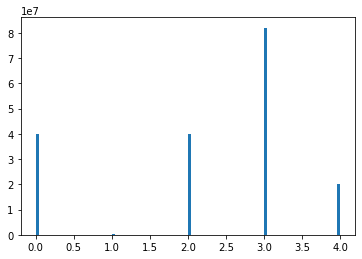

In [33]:
###################################### clustering (Kmeans) ##########################
from datetime import datetime
from time import time
from sklearn.cluster import KMeans
from cuml import KMeans as cuKMeans

sta = time()

training_data = np.reshape(sync_data, (nb_files*nx_map*ny_map, nb_channels))
where_nan = np.isnan(training_data)
training_data[where_nan] = -99.

# kmeans = KMeans(n_clusters=5).fit(sync_data)
# labels = kmeans.predict(sync_data)
# mid = time()

cukmeans = cuKMeans(n_clusters=5).fit(training_data)
culabels = cukmeans.predict(training_data)
end = time()

plt.hist(culabels, 100)

# print('sklearn Kmeans:', mid-sta)
# print('cuml Kmeans:', end-mid)
print('cuml Kmeans:', end)

(360, 720)


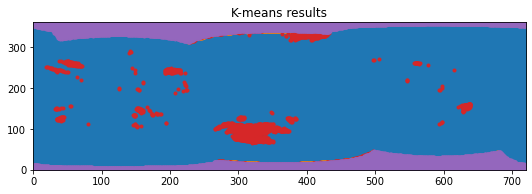

/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


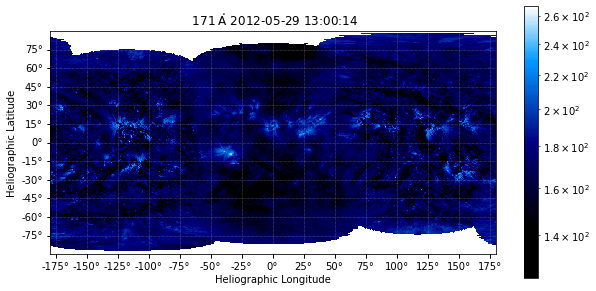

/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


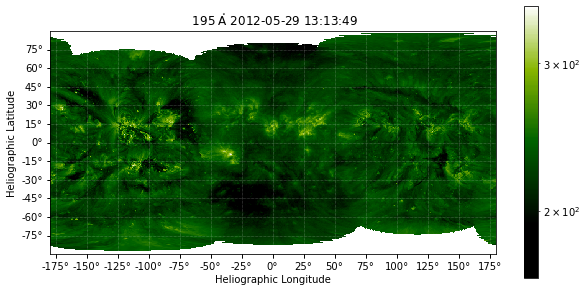

/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


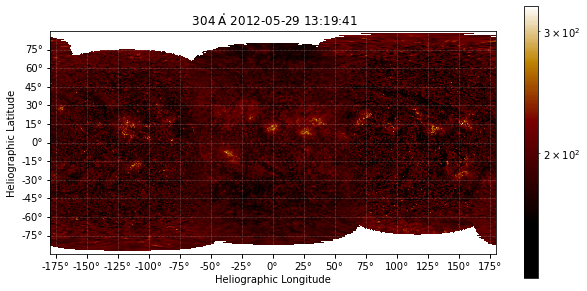

In [43]:
#%matplotlib notebook
culabels = cukmeans.predict(sync_data[0, :, :, :].reshape(nx_map*ny_map, nb_channels))
culabels = np.reshape(culabels, (nx_map, ny_map))
print(culabels.shape)

x = np.zeros((nx_map, ny_map,))
y = np.zeros((nx_map, ny_map))
for i in range(nx_map):
    x[i, :] = i
for j in range(ny_map):
    y[:, j] = j        
    
plt.figure(figsize=(7.5, 5))
plt.subplot(2,1,1)
for i in np.arange(5):
    idx = np.where(culabels==i)
    
    plt.plot(y[idx], x[idx], '.')
plt.title('K-means results')
plt.tight_layout()
plt.xlim(0, ny_map)
plt.ylim(0, nx_map)
plt.show()

sync_class = synchronic_map()
sync_tmp = sunpy.map.Map(filenames_171[0])
sync_class.plot_map_object(sync_tmp, cmaps[0])
sync_tmp = sunpy.map.Map(filenames_195[0])
sync_class.plot_map_object(sync_tmp, cmaps[1])
sync_tmp = sunpy.map.Map(filenames_304[0])
sync_class.plot_map_object(sync_tmp, cmaps[2])

cuml Kmeans: 1598562280.2327757


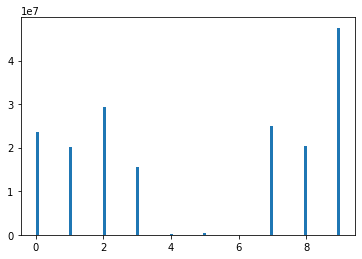

In [6]:
###################################### clustering (Kmeans) ##########################
from datetime import datetime
from time import time
from sklearn.cluster import KMeans
from cuml import KMeans as cuKMeans

sta = time()

training_data = np.reshape(sync_data, (nb_files*nx_map*ny_map, nb_channels))
where_nan = np.isnan(training_data)
training_data[where_nan] = -99.

# kmeans = KMeans(n_clusters=5).fit(sync_data)
# labels = kmeans.predict(sync_data)
# mid = time()

cukmeans = cuKMeans(n_clusters=10).fit(training_data)
culabels = cukmeans.predict(training_data)
end = time()

plt.hist(culabels, 100)

# print('sklearn Kmeans:', mid-sta)
# print('cuml Kmeans:', end-mid)
print('cuml Kmeans:', end)

In [7]:
print('cuml Kmeans:', end-sta)

cuml Kmeans: 34.157747745513916


(360, 720)


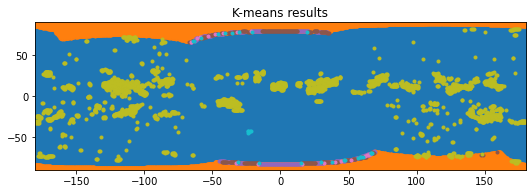

/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


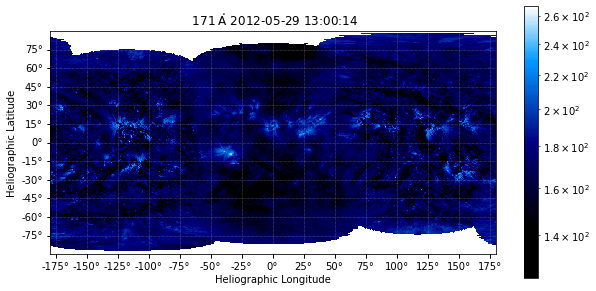

/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


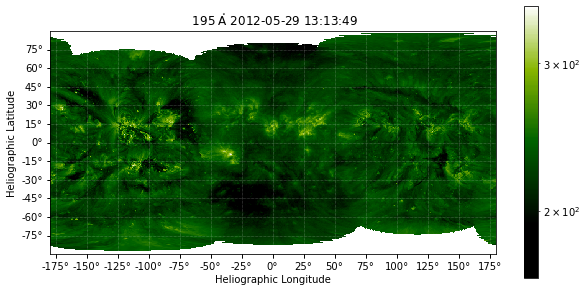

/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/opt/conda/envs/rapids/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


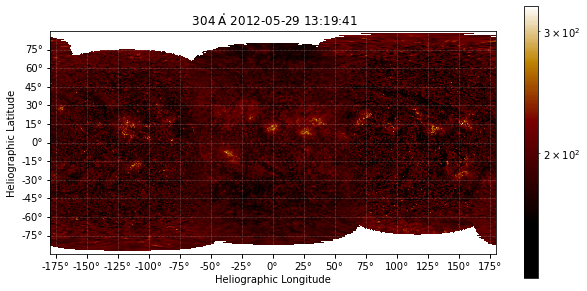

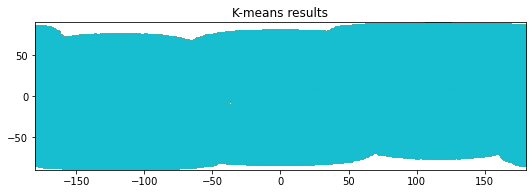

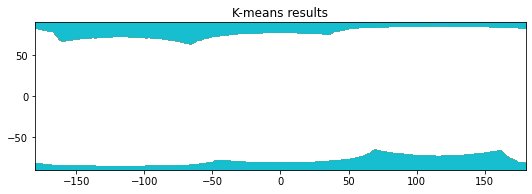

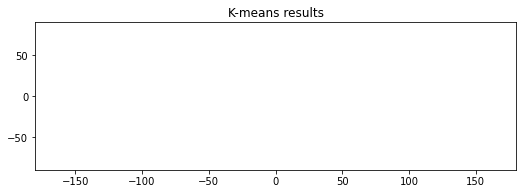

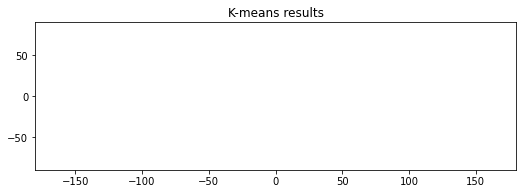

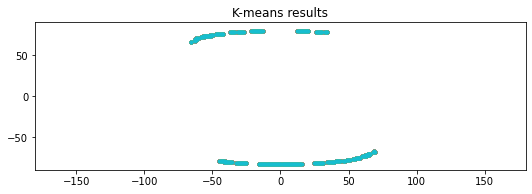

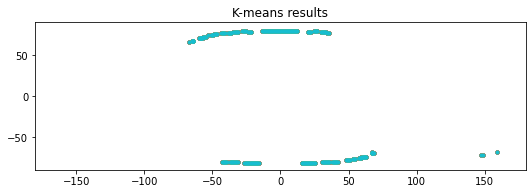

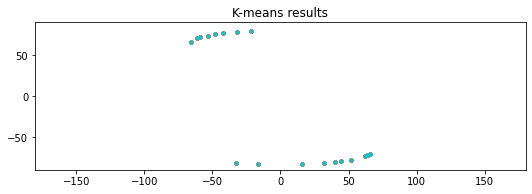

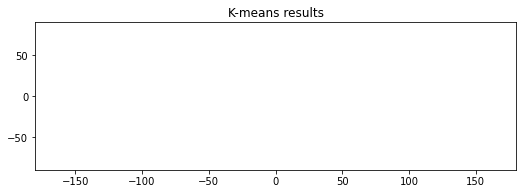

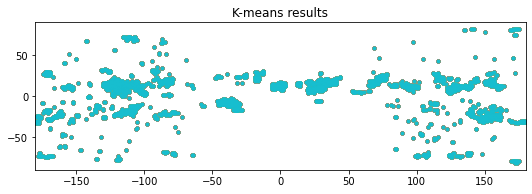

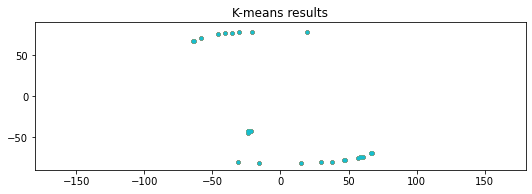

In [8]:
#%matplotlib notebook
culabels = cukmeans.predict(sync_data[0, :, :, :].reshape(nx_map*ny_map, nb_channels))
culabels = np.reshape(culabels, (nx_map, ny_map))
print(culabels.shape)

x = np.zeros((nx_map, ny_map,))
y = np.zeros((nx_map, ny_map))
for i in range(nx_map):
    x[i, :] = -90+0.5*i
for j in range(ny_map):
    y[:, j] = -180+0.5*j        
    
plt.figure(figsize=(7.5, 5))
plt.subplot(2,1,1)
for i in np.arange(10):
    idx = np.where(culabels==i)
    
    plt.plot(y[idx], x[idx], '.')
plt.title('K-means results')
plt.tight_layout()
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()

sync_class = synchronic_map()
sync_tmp = sunpy.map.Map(filenames_171[0])
sync_class.plot_map_object(sync_tmp, cmaps[0])
sync_tmp = sunpy.map.Map(filenames_195[0])
sync_class.plot_map_object(sync_tmp, cmaps[1])
sync_tmp = sunpy.map.Map(filenames_304[0])
sync_class.plot_map_object(sync_tmp, cmaps[2])

# Show classes
for i in np.arange(10):
    plt.figure(figsize=(7.5, 5))
    plt.subplot(2,1,1)
    idx = np.where(culabels==i)
    
    plt.plot(y[idx], x[idx], '.')
    plt.title('K-means results')
    plt.tight_layout()
    plt.xlim(-180, 180)
    plt.ylim(-90, 90)
    plt.show()

In [18]:
# Test data

filenames_masks = sorted(glob.glob(path_to_files+'EUVI*'))